**Tasks**

**Dense networks**

Finally, try with neural networks

- 1-layer dense network i.e. no hidden layer, just the input and output ones
- 2-layer dense network i.e. one hidden layer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
%matplotlib inline

In [2]:
# Load the numpy .npy file
train_dataset_array = np.load("train_dataset_array.npy")
train_dataset_array_labels = np.load("train_dataset_array_labels.npy")
train_dataset_array_features = np.load("train_features.npy")

print('Train data loaded')

Train data loaded


In [3]:
# Load the numpy .npy file
test_dataset_array = np.load("test_dataset_array.npy")
test_dataset_array_labels = np.load("test_dataset_array_labels.npy")
test_dataset_array_features = np.load("test_features.npy")

print('Test data loaded')

Test data loaded


In [4]:
# Load the numpy .npy file
valid_dataset_array = np.load("valid_dataset_array.npy")
valid_dataset_array_labels = np.load("valid_dataset_array_labels.npy")
valid_dataset_array_features = np.load("valid_features.npy")

print('Validation data loaded')

Validation data loaded


In [5]:
# Create X/y arrays
X_tr = train_dataset_array_features
y_tr = train_dataset_array_labels

print('X:', X_tr.shape, X_tr.dtype)
print('y:', y_tr.shape, y_tr.dtype)

X: (280, 1024) float32
y: (280,) int64


In [6]:
# Create X/y arrays
X_te = test_dataset_array_features
y_te = test_dataset_array_labels

print('X:', X_te.shape, X_te.dtype)
print('y:', y_te.shape, y_te.dtype)

X: (50, 1024) float32
y: (50,) int64


In [7]:
# Create X/y arrays
X_val = valid_dataset_array_features
y_val = valid_dataset_array_labels

print('X_val:', X_val.shape, X_val.dtype)
print('y_val:', y_val.shape, y_val.dtype)

X_val: (139, 1024) float32
y_val: (139,) int64


In [8]:
# We scale our features since gradient descent is sensitive to the scale of the data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)
print('Train shape:', X_tr.shape)
print('Validation shape:', X_val.shape)
print('Test shape:', X_te.shape)

Train shape: (280, 1024)
Validation shape: (139, 1024)
Test shape: (50, 1024)


In [9]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n 
    np.random.shuffle(shuffled_idx)
    # Enumerate indexes by steps of batch_size
    # i: e, b, 2b, 3b, 4b, .. where b is the batch size 
    for i in range(0, len(y), batch_size):
    # Batch indexes
        batch_idx = shuffled_idx[i :i+batch_size] 
        yield X[batch_idx], y[batch_idx]

In [10]:
# first create 1-layer dense network i.e. no hidden layer, just the input and output ones
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype = tf.float32, shape=[None, X_tr.shape[1]])
    y = tf.placeholder(dtype = tf.int32, shape=[None])    
    
    # Output layer, no hidden layer
    logits = tf.layers.dense(
        X, 6, activation = None, #No activation function
        kernel_initializer = tf.variance_scaling_initializer(scale = 1, seed = 0),
        bias_initializer = tf.zeros_initializer(),
        name = 'output') 
    
    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse = True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [11]:
with graph.as_default():
    
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)
    
    # Applying dropout 
    inputs = tf.layers.dropout(X, rate=0.5, seed=0.5, training=training)
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Learning rate placeholder
    lr = tf.placeholder(dtype=tf.float32)
    # Create the optimizer
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    # L2 term
    l2_term_W2 = tf.nn.l2_loss(W2)
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    # Loss function
    loss = mean_ce + alpha * (l2_term_W2)
        
    # Create a training operation
    train_op = gd.minimize(loss)
    
    # Computing predictions/accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Instructions for updating:
Use keras.layers.dropout instead.


In [12]:
# Validation Accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(200):
        batch_acc = []
        
        for X_batch,y_batch in get_batches(X_tr, y_tr, 32):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy],
                                     feed_dict={X: X_batch,
                                                y: y_batch, lr: 0.001,
                                                training: True,
                                                alpha: 0.001})
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)
            
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, 
                             feed_dict={X: X_val, 
                                        y: y_val, 
                                        training:False})
        
        valid_acc_values.append(valid_acc)
              
        
        if (epoch+1)%5==0: 
            print('Epoch{} - valid: {:.3f} train: {:.3f} (mean)'.format(epoch+1, 
                                                                    valid_acc, 
                                                                    np.mean(batch_acc)))   
        
    weights_hidden = W2.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, 
                        feed_dict={X: X_te, 
                                   y: y_te})
    
    print('Accuracy of our Network on the test set: {:.3f}'.format(test_acc))   
    print('Accuracy of our Network on the validation set: {:.3f}'.format(valid_acc))   

Epoch5 - valid: 0.547 train: 0.537 (mean)
Epoch10 - valid: 0.705 train: 0.744 (mean)
Epoch15 - valid: 0.748 train: 0.836 (mean)
Epoch20 - valid: 0.748 train: 0.867 (mean)
Epoch25 - valid: 0.799 train: 0.889 (mean)
Epoch30 - valid: 0.827 train: 0.905 (mean)
Epoch35 - valid: 0.827 train: 0.927 (mean)
Epoch40 - valid: 0.827 train: 0.939 (mean)
Epoch45 - valid: 0.849 train: 0.943 (mean)
Epoch50 - valid: 0.849 train: 0.972 (mean)
Epoch55 - valid: 0.849 train: 0.979 (mean)
Epoch60 - valid: 0.849 train: 0.983 (mean)
Epoch65 - valid: 0.856 train: 0.986 (mean)
Epoch70 - valid: 0.856 train: 0.990 (mean)
Epoch75 - valid: 0.856 train: 0.990 (mean)
Epoch80 - valid: 0.856 train: 0.988 (mean)
Epoch85 - valid: 0.856 train: 0.990 (mean)
Epoch90 - valid: 0.849 train: 0.993 (mean)
Epoch95 - valid: 0.856 train: 0.993 (mean)
Epoch100 - valid: 0.856 train: 0.997 (mean)
Epoch105 - valid: 0.849 train: 0.997 (mean)
Epoch110 - valid: 0.849 train: 0.997 (mean)
Epoch115 - valid: 0.849 train: 0.997 (mean)
Epoch120

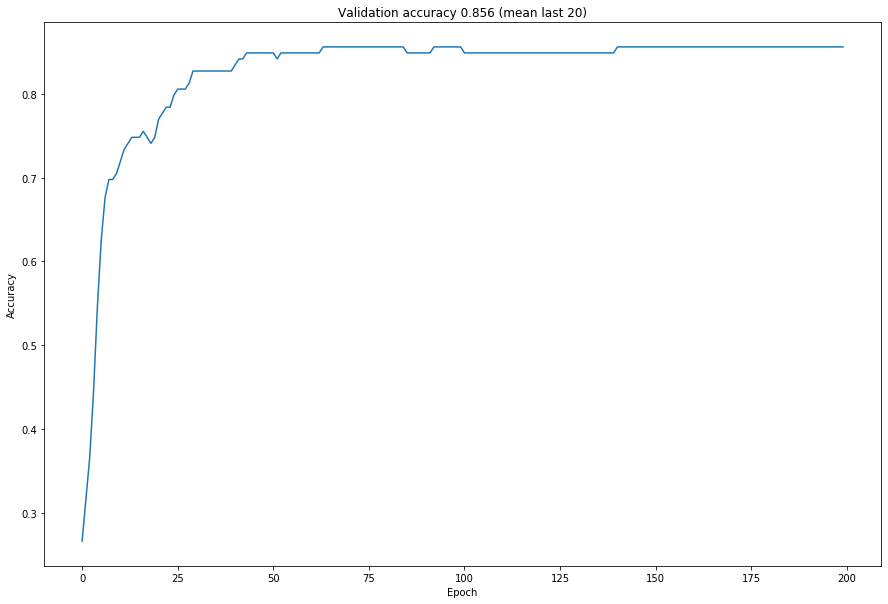

In [13]:
fig = plt.figure(figsize=(15, 10))
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 20)'.format(np.mean(valid_acc_values[-20:])))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [14]:
# Create a 2-layer dense network i.e. one hidden layer
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype = tf.float32, shape=[None, X_tr.shape[1]])
    y = tf.placeholder(dtype = tf.int32, shape=[None])
    
    # Hidden layer with 64 units
    hidden = tf.layers.dense(
        X, 64, activation = tf.nn.relu,  # ReLu
        kernel_initializer = tf.variance_scaling_initializer(scale = 2, seed = 0),
        bias_initializer=tf.zeros_initializer(), 
        name = 'hidden')
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 6, activation = None, #No activation function
        kernel_initializer = tf.variance_scaling_initializer(scale = 1, seed = 0),
        bias_initializer = tf.zeros_initializer(),
        name = 'output') 
    
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse = True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')
   
    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse = True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

In [15]:
with graph.as_default():
    
    # Create training placeholder
    training = tf.placeholder(dtype=tf.bool)
    
    # Applying dropout 
    inputs = tf.layers.dropout(X, rate=0.5, seed=0.5, training=training)
    hidden = tf.layers.dropout(hidden, rate=0.5, seed=0.5, training=training) 
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Learning rate placeholder
    lr = tf.placeholder(dtype=tf.float32)
    # Create the optimizer
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    # L2 term
    l2_term_W1 = tf.nn.l2_loss(W1)
    l2_term_W2 = tf.nn.l2_loss(W2)
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    # Loss function
    loss = mean_ce + alpha * (l2_term_W1 + l2_term_W2)
        
    # Create a training operation
    train_op = gd.minimize(loss)
    
    # Computing predictions/accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [16]:
# Validation Accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(200):
        batch_acc = []
        
        for X_batch,y_batch in get_batches(X_tr, y_tr, 32):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy],
                                     feed_dict={X: X_batch,
                                                y: y_batch, lr: 0.001,
                                                training: True,
                                                alpha: 0.001})
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)
            
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, 
                             feed_dict={X: X_val, 
                                        y: y_val, 
                                        training:False})
        
        valid_acc_values.append(valid_acc)
              
        
        if (epoch+1)%5==0: 
            print('Epoch{} - valid: {:.3f} train: {:.3f} (mean)'.format(epoch+1, 
                                                                    valid_acc, 
                                                                    np.mean(batch_acc)))   
        
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, 
                        feed_dict={X: X_te, 
                                   y: y_te})
    
    print('Accuracy of our Network on the test set: {:.3f}'.format(test_acc))   
    print('Accuracy of our Network on the validation set: {:.3f}'.format(valid_acc))   

    weights_hidden = W1.eval()
    weights_hidden = W2.eval()

Epoch5 - valid: 0.317 train: 0.358 (mean)
Epoch10 - valid: 0.475 train: 0.542 (mean)
Epoch15 - valid: 0.604 train: 0.699 (mean)
Epoch20 - valid: 0.669 train: 0.760 (mean)
Epoch25 - valid: 0.712 train: 0.811 (mean)
Epoch30 - valid: 0.748 train: 0.844 (mean)
Epoch35 - valid: 0.755 train: 0.876 (mean)
Epoch40 - valid: 0.777 train: 0.898 (mean)
Epoch45 - valid: 0.784 train: 0.914 (mean)
Epoch50 - valid: 0.791 train: 0.922 (mean)
Epoch55 - valid: 0.799 train: 0.940 (mean)
Epoch60 - valid: 0.799 train: 0.941 (mean)
Epoch65 - valid: 0.799 train: 0.947 (mean)
Epoch70 - valid: 0.806 train: 0.955 (mean)
Epoch75 - valid: 0.799 train: 0.959 (mean)
Epoch80 - valid: 0.806 train: 0.964 (mean)
Epoch85 - valid: 0.820 train: 0.969 (mean)
Epoch90 - valid: 0.820 train: 0.972 (mean)
Epoch95 - valid: 0.827 train: 0.973 (mean)
Epoch100 - valid: 0.827 train: 0.981 (mean)
Epoch105 - valid: 0.835 train: 0.986 (mean)
Epoch110 - valid: 0.835 train: 0.986 (mean)
Epoch115 - valid: 0.835 train: 0.986 (mean)
Epoch120

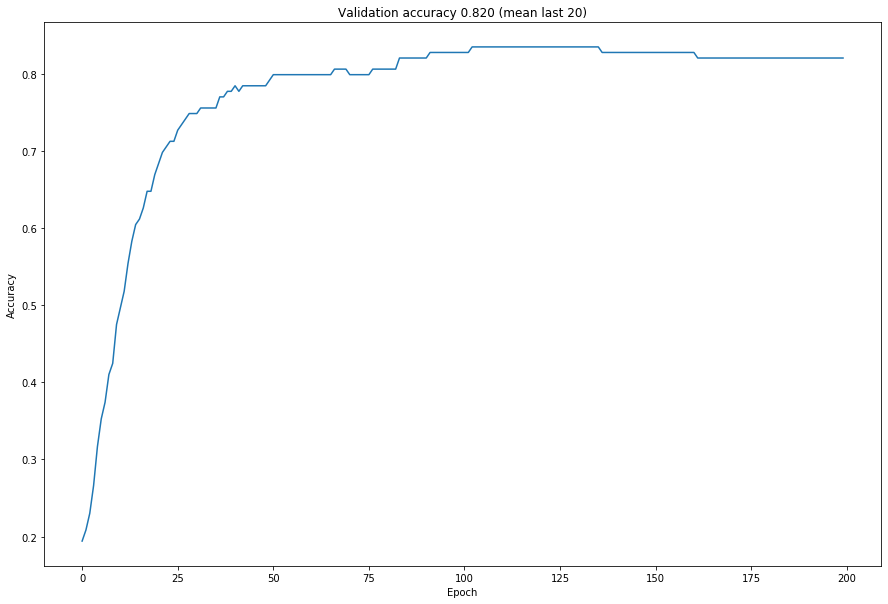

In [17]:
fig = plt.figure(figsize=(15, 10))
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 20)'.format(np.mean(valid_acc_values[-20:])))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()